In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
- datetime - 시간별 날짜 + 타임스탬프
- 계절 - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
- 휴일 - 해당 날이 공휴일로 간주되는지 여부
- 근무일 - 그 날이 주말도 휴일도 아닌지의 여부
- 풍상을 일으키다
    - 1: 맑음, 구름 거의 없음, 부분적으로 흐림, 부분적으로 흐림
    - 2: 안개 + 흐림, 안개 + 깨진 구름, 안개 + 구름 몇 개, 안개
    - 3: 가벼운 눈, 가벼운 비 + 뇌우 + 산란운, 가벼운 비 + 산란운
    - 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개
- 섭씨 온도
- 온도 - 섭씨 단위의 "느낌" 온도
- 습도 - 상대습도
- 풍속 - 풍속
- 캐주얼 - 등록되지 않은 사용자 임대 시작 수
- registered - 시작된 등록된 사용자 대여 수
- 개수 - 총 임대 수
'''

In [11]:
train = pd.read_csv("train.csv")

In [12]:
test = pd.read_csv("train.csv")

In [13]:
submission = pd.read_csv("sampleSubmission.csv")

## 데이터 구조 확인

In [14]:
print(train.shape)
print(test.shape)
print(submission.shape)

(10886, 12)
(10886, 12)
(6493, 2)


In [15]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


#### train 파일에는 12개의 컬럼, test에는 9개의 컬럼이 있는걸 확인할 수 있다.

In [16]:
test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [122]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## 데이터 자료 분석 및 필요에 의한 전처리 

In [11]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

### 1. datetime 분석 및 정리

#### datetime 중 년, 월, 일이 명시 되어 있지만 "일" 날짜를 가르키는 날은 19일 밖에 없으며 분,초는 나타내지 않는걸 확인

In [87]:
train[train["datetime"].between('2011-01-01', '2011-01-31')].tail(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
428,2011-01-19 21:00:00,1,0,1,1,13.12,14.395,49,27.9993,4,55,59
429,2011-01-19 22:00:00,1,0,1,1,12.30,15.150,52,11.0014,6,53,59
430,2011-01-19 23:00:00,1,0,1,1,12.30,13.635,52,31.0009,1,27,28


#### 오브젝트로 이루어진 날짜와 시간 형태를 데이트타임으로 변경 후 년/월/시 기준으로 나누었고 일,분,초는 제외함

In [153]:
train["datetime"] = pd.to_datetime(train["datetime"])
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour

In [89]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2


#### holiday = 공휴일, workingday = 평일로 임의적으로 요일을 표시하여 요일별 자전거 총 대여량 검사

In [154]:
train["day"] = train['datetime'].dt.day_name()

In [125]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,0,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,2,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,3,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,4,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,Wednesday
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,20,Wednesday
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,21,Wednesday
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,22,Wednesday


In [92]:
train["day"].value_counts()

Saturday     1584
Sunday       1579
Thursday     1553
Monday       1551
Wednesday    1551
Tuesday      1539
Friday       1529
Name: day, dtype: int64

In [93]:
train.groupby("day", as_index = False)["count"].mean().sort_values("count", ascending = False)

,day,count
0,Friday,197.844343
4,Thursday,197.296201
2,Saturday,196.665404
1,Monday,190.390716
5,Tuesday,189.723847
6,Wednesday,188.411348
3,Sunday,180.839772


#### 시즌별/년도별/월별/시간별 총 자전거 대여량 수 비교

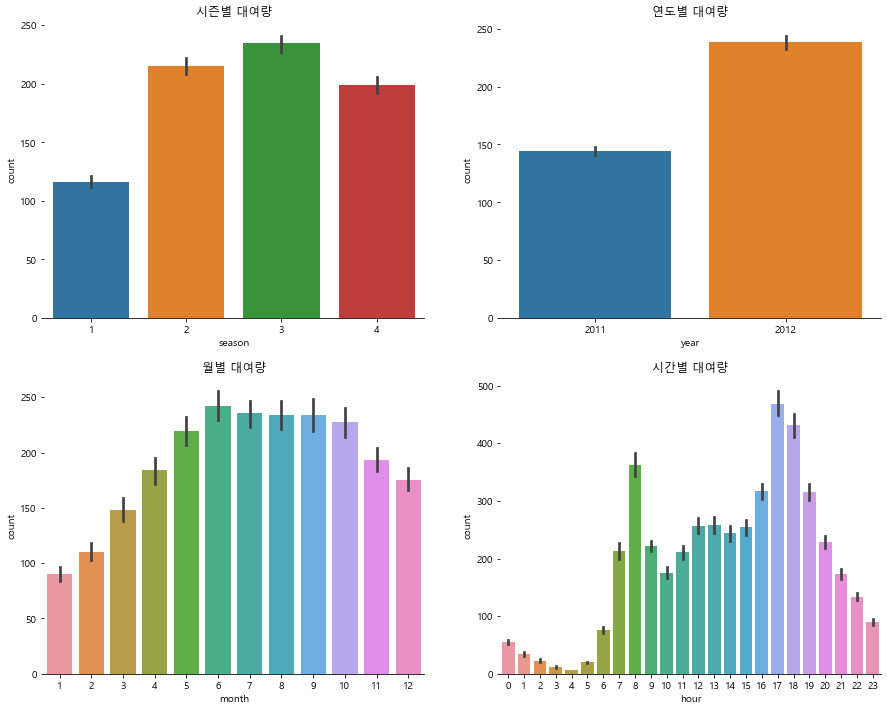

In [94]:
plt.rcParams['font.family'] = 'Malgun Gothic'
f,axes = plt.subplots(2,2,figsize = (15,12))

sns.despine(left = True)

sns.barplot(x = "season" , y = 'count' , data = train, ax =  axes[0,0]) # 1번째 record의 자료
sns.barplot(x = "year" , y = 'count' , data = train, ax = axes[0,1])

sns.barplot(x = "month", y = "count", data=train, ax = axes[1,0]) # 2번째 record의 자료
sns.barplot(x = "hour", y = 'count', data = train, ax = axes[1,1])

# 텍스트
axes[0,0].set(title="시즌별 대여량")
axes[0,1].set(title="연도별 대여량")
axes[1,0].set(title="월별 대여량")
axes[1,1].set(title="시간별 대여량");

#### 위에서 날짜가 19일 까지 밖에 없어서 잘랐기 때문에 요일 별, 공휴일 별, 평일별 자전거 대여량 비교

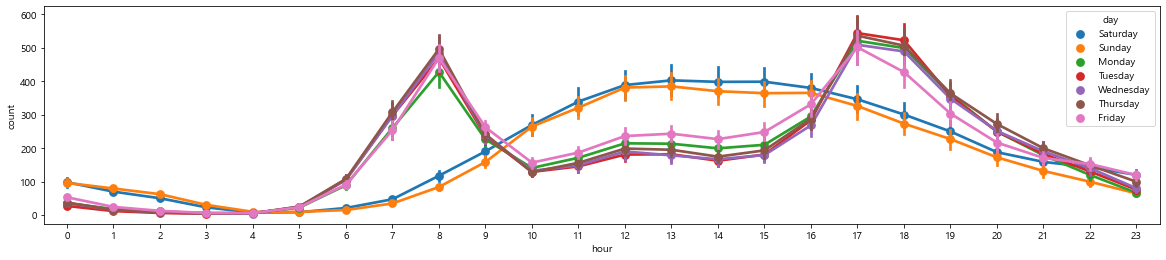

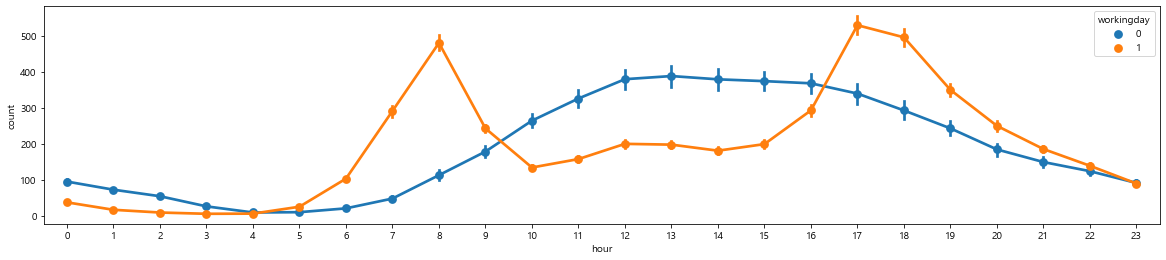

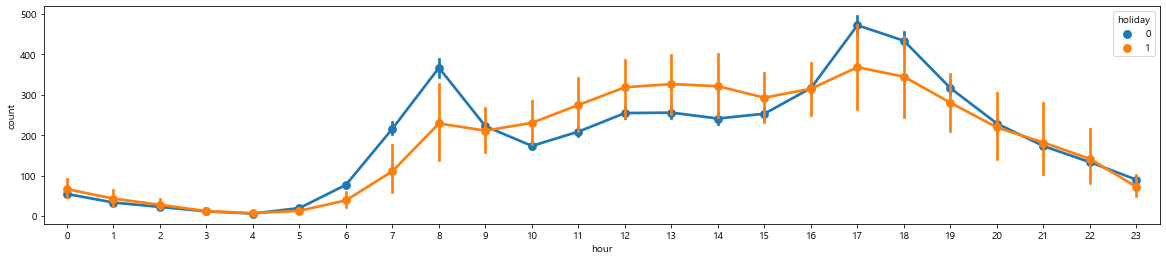

In [95]:
for i in ["day", "workingday", "holiday"] :
    plt.figure(figsize = (20,4))
    sns.pointplot(x = 'hour', y = 'count', data = train, hue = i)
    plt.show()

#### season : 1 = 봄(1,2,3), 2 = 여름(4,5,6), 3 = 가을(7,8,9), 4 = 겨울(10,11,12)
* 1. 가을에 총 대여 추이량이 가장 크다
* 2. 2011년 보다 2012년에 자전거 이용률이 더 많다 
* 3. 월별은 11 ~ 4월을 제외한 나머지는 비슷한데 아마도 기온에 따른 영향을 많이 받았을듯
* 4. 시간은 8시, 17시,18시가 가장 큰 값을 나타내는 것을 보니 출근 / 퇴근 시간대에 이용률이 크다

> 본 계절과 전혀 상관 없는 월을 시즌으로 나타냈기 때문에 정리해줄 필요가 있음\
> 시간은 구간화 하면 좋을 것 같음

In [96]:
train["season"]

0        1
1        1
2        1
3        1
4        1
        ..
10881    4
10882    4
10883    4
10884    4
10885    4
Name: season, Length: 10886, dtype: int64

##### 시간별 비회원, 회원, 총 대여수 비교

In [126]:
hourby_count = train.groupby("hour")[["registered", "casual", "count"]].mean()

In [141]:
hourby_count.head(3)

,registered,casual,count
hour,,,
0,44.826374,10.312088,55.138462
1,27.345815,6.513216,33.859031
2,18.080357,4.819196,22.899554


In [99]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  hour        10886 non-null  int64         
 15  day         10886 non-null  object        
dtypes: datetime64[ns](1), 

#### 모든 컬럼의 속성값을 일일히 확인하기 어려우니 상관관계가 어떻게 나타나는지 확인

In [100]:
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.004797,0.971524,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.012021,0.001731,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.002482,-0.003394,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.012548,0.012144,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.061226,0.257589,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.058540,0.264173,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,0.204537,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.015221,-0.150192,0.146631
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.145241,0.092722,0.302045
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.264265,0.169451,0.380540


C:\Users\user\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


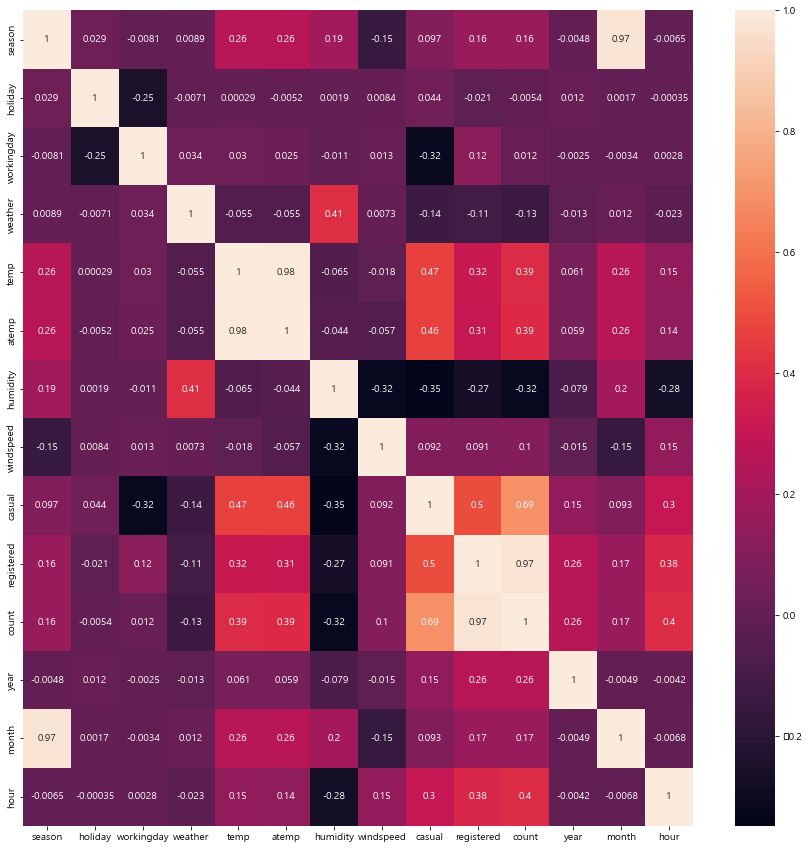

In [101]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), annot = True )

#### 날씨와 기온에 크게 대여량이 영향 받을 것 같았지만 그런건 아닌 것 같아서 날씨, 풍속, 온도를 하나씩 봐야할듯

In [142]:
train[train["weather"] == 4 ]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012,1,18,Monday


In [103]:
train["windspeed"].value_counts()

0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: windspeed, dtype: int64

In [129]:
train.groupby(["weather","windspeed"])["count"].median()

weather  windspeed
1        0.0000       107.0
         6.0032       100.0
         7.0015       117.0
         8.9981       144.0
         11.0014      172.0
                      ...  
3        40.9973      125.5
         43.0006       33.0
         43.9989      375.0
         56.9969      269.5
4        6.0032       164.0
Name: count, Length: 76, dtype: float64

In [130]:
train[train["windspeed"] == 0 ]["weather"].value_counts()

1    901
2    338
3     74
Name: weather, dtype: int64

#### 1. 이상한 기준을 갖고 있는 시즌을 정상적인 달로 바꾸기

#### 2. 풍속이 0인 경우 처리하기

#### 3. 요일을 나타내는 Day 컬럼은 주말과 평일이 큰 차이 없기 때문에 holiday, workingday 를 놔두고 day는 삭제

#### 4. 학습에 필요한 변수 목록 정리하기

#### season : 1 = 봄(1,2,3), 2 = 여름(4,5,6), 3 = 가을(7,8,9), 4 = 겨울(10,11,12)

In [155]:
train["season2"] = np.where(train["month"].isin([3,4,5]), 1,
np.where(train["month"].isin([6,7,8]), 2,
np.where(train["month"].isin([9,10,11]), 3, 4)))

In [145]:
train[["weather", "season2"]].sample(10)

,weather,season2
8785,2,2
8992,1,2
5104,2,4
2194,1,1
10262,2,3
929,1,1
2938,1,2
9755,1,3
6733,1,1
4493,3,3


In [146]:
train.groupby("season2")["windspeed"].mean()

season2
1    14.407636
2    11.766679
3    11.976541
4    13.057125
Name: windspeed, dtype: float64

In [147]:
train.groupby("weather")["windspeed"].mean()

weather
1    12.892542
2    12.179905
3    14.071248
4     6.003200
Name: windspeed, dtype: float64

#### 분기별 풍속인 0인 경우를 평균으로 바꾸기 위해 0을 모두 null 값으로 변환

In [148]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
hour          0
day           0
season2       0
dtype: int64

In [156]:
train["windspeed"] = train["windspeed"].replace(0, np.NaN)

In [157]:
train["windspeed"].isnull().sum()

1313

In [161]:
train.groupby("weather")["windspeed"].mean()

weather
1    14.739018
2    13.829267
3    15.397710
4     6.003200
Name: windspeed, dtype: float64

In [166]:
weather_group = train.groupby("weather")

In [167]:
weather_group.first()

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day,season2
weather,,,,,,,,,,,,,,,,
1,2011-01-01 00:00:00,1,0,0,9.84,14.395,81,16.9979,3,13,16,2011,1,0,Saturday,4
2,2011-01-01 05:00:00,1,0,0,9.84,12.880,75,6.0032,0,1,1,2011,1,5,Saturday,4
3,2011-01-01 18:00:00,1,0,0,17.22,21.210,88,16.9979,9,26,35,2011,1,18,Saturday,4
4,2012-01-09 18:00:00,1,0,1,8.20,11.365,86,6.0032,6,158,164,2012,1,18,Monday,4


#### null 값으로 바꾼 풍속을 날씨 별 평균으로 변경

In [168]:
fillna_dic = {1 : 14.739018, 2 : 13.829267, 3 : 15.397710, 4 : 6.003200}

In [169]:
fillna_func = lambda g : g.fillna(fillna_dic[g.name])

In [170]:
train["windspeed"] = weather_group.windspeed.transform(fillna_func)

In [171]:
train["windspeed"].value_counts()

8.998100     1120
11.001400    1057
12.998000    1042
7.001500     1034
15.001300     961
14.739018     901
6.003200      872
16.997900     824
19.001200     676
19.999500     492
22.002800     372
13.829267     338
23.999400     274
26.002700     235
27.999300     187
30.002600     111
31.000900      89
32.997500      80
15.397710      74
35.000800      58
39.000700      27
36.997400      22
43.000600      12
40.997300      11
43.998900       8
46.002200       3
56.996900       2
47.998800       2
51.998700       1
50.002100       1
Name: windspeed, dtype: int64

In [172]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
hour          0
day           0
season2       0
dtype: int64

In [173]:
train.groupby("weather")["windspeed"].mean()

weather
1    14.739018
2    13.829267
3    15.397710
4     6.003200
Name: windspeed, dtype: float64

#### 주말과 평일의 구분이 크지 않기 때문에 요일을 나타냈던 컬럼은 삭제

In [176]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,day,season2
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,14.739018,3,13,16,2011,1,0,Saturday,4
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,14.739018,8,32,40,2011,1,1,Saturday,4
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,14.739018,5,27,32,2011,1,2,Saturday,4
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,14.739018,3,10,13,2011,1,3,Saturday,4
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,14.739018,0,1,1,2011,1,4,Saturday,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7,329,336,2012,12,19,Wednesday,4
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10,231,241,2012,12,20,Wednesday,4
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4,164,168,2012,12,21,Wednesday,4
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003200,12,117,129,2012,12,22,Wednesday,4


In [178]:
train.drop("day", axis = 1, inplace = True)

In [179]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,season2
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,14.739018,3,13,16,2011,1,0,4
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,14.739018,8,32,40,2011,1,1,4
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,14.739018,5,27,32,2011,1,2,4


#### feature로 사용하게 될 변수 목록 정리

In [ ]:
train.columns

In [ ]:
feature = holiday, workingday, weather, temp, atemp, humidity, windspeed,year, month, hour ,season2 

In [ ]:
label = count

In [17]:
train[["temp","atemp"]]

,temp,atemp
0,9.84,14.395
1,9.02,13.635
2,9.02,13.635
3,9.84,14.395
4,9.84,14.395
...,...,...
10881,15.58,19.695
10882,14.76,17.425
10883,13.94,15.910
10884,13.94,17.425
